In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
# ===== ПОДГОТОВКА СРЕДЫ =====

# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

# Создание и переход в рабочую директорию
import os
work_dir = '/content/drive/MyDrive/Colab Notebooks/is_lab2'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

# Создаем папку для результатов
os.makedirs('out', exist_ok=True)

# СКАЧИВАНИЕ ФАЙЛОВ
dataset_name = 'WBC'  # Ваш вариант для k=5
base_url = "http://uit.mpei.ru/git/main/is_dnn/raw/branch/main/labworks/LW2/"

# Скачивание библиотеки
!wget -N {base_url}lab02_lib.py

# Скачивание обучающей и тестовой выборок
!wget -N {base_url}data/{dataset_name}_train.txt
!wget -N {base_url}data/{dataset_name}_test.txt

# Переименование файлов для удобства
!cp {dataset_name}_train.txt train.txt
!cp {dataset_name}_test.txt test.txt

print("Файлы успешно скачаны!")
print("Содержимое рабочей директории:")
!ls -la

In [ ]:
# Импорт библиотек (после скачивания lab02_lib.py)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import lab02_lib as lib

# Параметры для варианта 5 (номер бригады k=5)
k = 5  # номер бригады
center_coords = (k, k)  # координаты центра (5, 5)

print("Лабораторная работа №2: Обнаружение аномалий с помощью автокодировщиков")
print("Вариант 5 (номер бригады k=5) - данные WBC")
print("=" * 70)
print("Подготовка среды завершена успешно!")

In [ ]:
# ===== ЗАДАНИЕ 1: Работа с двумерными синтетическими данными =====

# 1. Генерация индивидуального набора двумерных данных
print("Генерация синтетических данных с центром в (5, 5)...")

# Используем функцию из библиотеки lab02_lib для генерации данных
data = lib.datagen(k, k, 1000, 2)

print(f"Сгенерировано {len(data)} точек")
print(f"Центр данных: {center_coords}")
print(f"Размерность данных: {data.shape}")

In [ ]:
# 2. Создание и обучение автокодировщика AE1 (простая архитектура)
print("="*50)
print("Обучение AE1")
print("="*50)

# Создаем автокодировщик вручную для получения истории обучения
def create_simple_ae():
    model = Sequential()
    # Входной слой
    model.add(Dense(2, input_shape=(2,), activation='tanh'))
    # Скрытый слой (1 нейрон)
    model.add(Dense(1, activation='tanh'))
    # Выходной слой
    model.add(Dense(2, activation='linear'))
    return model

# Создаем и компилируем модель
ae1 = create_simple_ae()
ae1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("Архитектура AE1:")
ae1.summary()

# Обучаем модель с сохранением истории
print("\nНачало обучения AE1...")
history_ae1 = ae1.fit(data, data,
                      epochs=1000,
                      batch_size=32,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[EarlyStopping(patience=300, restore_best_weights=True)])

# Сохраняем модель
ae1.save('out/AE1.h5')

# Вычисляем ошибки реконструкции
X_pred_ae1 = ae1.predict(data)
reconstruction_errors_ae1 = np.mean(np.square(data - X_pred_ae1), axis=1)
threshold_ae1 = np.max(reconstruction_errors_ae1)  # Порог как максимальная ошибка

# Анализ результатов AE1
print("\nАнализ результатов AE1")
mse_ae1 = history_ae1.history['loss'][-1]
print(f"Финальная ошибка MSE AE1: {mse_ae1:.6f}")
print(f"Порог ошибки реконструкции AE1: {threshold_ae1:.6f}")

# Построение графиков
plt.figure(figsize=(15, 4))

# График 1: MSE по эпохам
plt.subplot(1, 3, 1)
plt.plot(history_ae1.history['loss'], label='Training Loss', color='blue')
plt.plot(history_ae1.history['val_loss'], label='Validation Loss', color='red')
plt.title('AE1: Ошибка обучения (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки реконструкции по точкам
plt.subplot(1, 3, 2)
plt.plot(reconstruction_errors_ae1, 'b-', alpha=0.7, linewidth=0.8)
plt.axhline(y=threshold_ae1, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae1:.2f}')
plt.title('AE1: Ошибки реконструкции')
plt.xlabel('Номер точки')
plt.ylabel('Ошибка реконструкции')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Гистограмма распределения ошибок
plt.subplot(1, 3, 3)
plt.hist(reconstruction_errors_ae1, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold_ae1, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae1:.2f}')
plt.title('AE1: Распределение ошибок')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/ae1_detailed_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем порог
with open('out/AE1_ire_th.txt', 'w') as f:
    f.write(str(threshold_ae1))

# Сохраняем для использования в следующих шагах
ae1_trained = ae1
IRE1 = reconstruction_errors_ae1
IREth1 = threshold_ae1

print(f"Обучение AE1 завершено!")
print(f"Минимальная ошибка: {np.min(IRE1):.6f}")
print(f"Максимальная ошибка: {np.max(IRE1):.6f}")
print(f"Средняя ошибка: {np.mean(IRE1):.6f}")

In [ ]:
# 3. Создание и обучение автокодировщика AE2 (архитектура по умолчанию)
print("="*50)
print("Обучение AE2")
print("="*50)

# Используем архитектуру по умолчанию: [2-3-2-1-2-3-2] (5 скрытых слоев: 3-2-1-2-3)
print("Используется архитектура по умолчанию: [2-3-2-1-2-3-2]")
print("Количество скрытых слоев: 5")
print("Нейроны в скрытых слоях: 3-2-1-2-3")

def create_ae2_default():
    model = Sequential()

    # Входной слой
    model.add(Dense(2, input_shape=(2,), activation='tanh'))

    # Скрытые слои по умолчанию: 3-2-1-2-3 (5 слоев)
    model.add(Dense(3, activation='tanh'))  # Скрытый слой 1
    model.add(Dense(2, activation='tanh'))  # Скрытый слой 2
    model.add(Dense(1, activation='tanh'))  # Скрытый слой 3 (bottleneck)
    model.add(Dense(2, activation='tanh'))  # Скрытый слой 4
    model.add(Dense(3, activation='tanh'))  # Скрытый слой 5

    # Выходной слой
    model.add(Dense(2, activation='linear'))

    return model

# Создаем и компилируем модель
ae2 = create_ae2_default()
ae2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("\nАрхитектура AE2:")
ae2.summary()

# Обучаем модель с сохранением истории (patience=300)
print(f"\nНачало обучения AE2 (patience=300)...")
history_ae2 = ae2.fit(data, data,
                      epochs=3000,
                      batch_size=32,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[EarlyStopping(patience=300, restore_best_weights=True)])

# Сохраняем модель
ae2.save('out/AE2.h5')

# Вычисляем ошибки реконструкции
X_pred_ae2 = ae2.predict(data)
reconstruction_errors_ae2 = np.mean(np.square(data - X_pred_ae2), axis=1)
threshold_ae2 = np.max(reconstruction_errors_ae2)  # Порог как максимальная ошибка

# Анализ результатов AE2
print("\n" + "="*50)
print("АНАЛИЗ РЕЗУЛЬТАТОВ AE2")
print("="*50)
mse_ae2 = history_ae2.history['loss'][-1]
print(f"Финальная ошибка MSE AE2: {mse_ae2:.6f}")
print(f"Порог ошибки реконструкции AE2: {threshold_ae2:.6f}")

# Проверка рекомендаций по MSE_stop
print("\nПРОВЕРКА РЕКОМЕНДАЦИЙ:")
if mse_ae2 >= 0.01:
    print("✓ MSE_stop для AE2 соответствует рекомендации (≥ 0.01)")
else:
    print("✗ MSE_stop для AE2 слишком низкая, возможно переобучение")

# Построение графиков
plt.figure(figsize=(15, 4))

# График 1: MSE по эпохам
plt.subplot(1, 3, 1)
plt.plot(history_ae2.history['loss'], label='Training Loss', color='green', linewidth=2)
plt.plot(history_ae2.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('AE2: Динамика обучения (MSE)', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки реконструкции по точкам
plt.subplot(1, 3, 2)
plt.plot(reconstruction_errors_ae2, 'g-', alpha=0.7, linewidth=0.8)
plt.axhline(y=threshold_ae2, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae2:.4f}')
plt.title('AE2: Ошибки реконструкции по точкам', fontsize=12, fontweight='bold')
plt.xlabel('Номер точки')
plt.ylabel('Ошибка реконструкции')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Гистограмма распределения ошибок
plt.subplot(1, 3, 3)
plt.hist(reconstruction_errors_ae2, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.axvline(threshold_ae2, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae2:.4f}')
plt.title('AE2: Распределение ошибок', fontsize=12, fontweight='bold')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/ae2_detailed_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем порог
with open('out/AE2_ire_th.txt', 'w') as f:
    f.write(str(threshold_ae2))

# Сохраняем для использования в следующих шагах
ae2_trained = ae2
IRE2 = reconstruction_errors_ae2
IREth2 = threshold_ae2

# Детальная статистика
print("\nДЕТАЛЬНАЯ СТАТИСТИКА AE2:")
print(f"Минимальная ошибка: {np.min(IRE2):.6f}")
print(f"Максимальная ошибка: {np.max(IRE2):.6f}")
print(f"Средняя ошибка: {np.mean(IRE2):.6f}")
print(f"Медианная ошибка: {np.median(IRE2):.6f}")
print(f"Стандартное отклонение: {np.std(IRE2):.6f}")
print(f"Количество точек с ошибкой выше порога: {np.sum(IRE2 > IREth2)}")
print(f"Процент точек выше порога: {np.sum(IRE2 > IREth2) / len(IRE2) * 100:.2f}%")

print(f"\nОбучение AE2 завершено!")
print(f"Архитектура: [2-3-2-1-2-3-2]")
print(f"Количество скрытых слоев: 5")
print(f"Нейроны в скрытых слоях: 3-2-1-2-3")

In [ ]:
# 7. Расчет характеристик качества обучения EDCA для AE1 и AE2
print("="*70)
print("РАСЧЕТ ХАРАКТЕРИСТИК КАЧЕСТВА ОБУЧЕНИЯ EDCA")
print("="*70)

# Параметры для расчета
numb_square = 20

print("\n" + "="*30)
print("РАСЧЕТ ДЛЯ AE1")
print("="*30)
xx, yy, Z1 = lib.square_calc(numb_square, data, ae1_trained, IREth1, '1', True)

print("\n" + "="*30)
print("РАСЧЕТ ДЛЯ AE2")
print("="*30)
xx, yy, Z2 = lib.square_calc(numb_square, data, ae2_trained, IREth2, '2', True)

# Сравнение областей аппроксимации
print("\n" + "="*50)
print("СРАВНЕНИЕ ОБЛАСТЕЙ АППРОКСИМАЦИИ AE1 И AE2")
print("="*50)
lib.plot2in1(data, xx, yy, Z1, Z2)





In [ ]:
# 8. УЛУЧШЕНИЕ АВТОКОДИРОВЩИКА AE2
print("="*70)
print("УЛУЧШЕНИЕ АВТОКОДИРОВЩИКА AE2 - ПОВТОРНОЕ ОБУЧЕНИЕ")
print("="*70)

# Пересоздаем AE2 с улучшенными параметрами обучения
def create_ae2_improved():
    model = Sequential()

    # Входной слой
    model.add(Dense(2, input_shape=(2,), activation='tanh'))

    # Та же архитектура: [2-3-2-1-2-3-2]
    model.add(Dense(3, activation='tanh'))   # Слой 1
    model.add(Dense(2, activation='tanh'))   # Слой 2
    model.add(Dense(1, activation='tanh'))   # Слой 3 (bottleneck)
    model.add(Dense(2, activation='tanh'))   # Слой 4
    model.add(Dense(3, activation='tanh'))   # Слой 5

    # Выходной слой
    model.add(Dense(2, activation='linear'))

    return model

# Создаем и компилируем улучшенную модель AE2
ae2_improved = create_ae2_improved()
ae2_improved.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

print("\nАрхитектура AE2 (улучшенный): [2-3-2-1-2-3-2]")
print("Количество скрытых слоев: 5")
ae2_improved.summary()

# Обучаем улучшенную модель AE2
print(f"\nНачало обучения улучшенного AE2 (5000 эпох, patience=400)...")
history_ae2_improved = ae2_improved.fit(data, data,
                      epochs=5000,
                      batch_size=16,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[EarlyStopping(patience=400, restore_best_weights=True)])

# Сохраняем улучшенную модель
ae2_improved.save('out/AE2_improved.h5')

# Вычисляем ошибки реконструкции для улучшенного AE2
X_pred_ae2_improved = ae2_improved.predict(data)
reconstruction_errors_ae2_improved = np.mean(np.square(data - X_pred_ae2_improved), axis=1)
threshold_ae2_improved = np.max(reconstruction_errors_ae2_improved)

# Анализ результатов улучшенного AE2
print("\n" + "="*50)
print("АНАЛИЗ РЕЗУЛЬТАТОВ УЛУЧШЕННОГО AE2")
print("="*50)
mse_ae2_improved = history_ae2_improved.history['loss'][-1]
print(f"Финальная ошибка MSE улучшенного AE2: {mse_ae2_improved:.6f}")
print(f"Порог ошибки реконструкции улучшенного AE2: {threshold_ae2_improved:.6f}")

# Построение графиков обучения улучшенного AE2
plt.figure(figsize=(15, 4))

# График 1: MSE по эпохам
plt.subplot(1, 3, 1)
plt.plot(history_ae2_improved.history['loss'], label='Training Loss', color='green', linewidth=2)
plt.plot(history_ae2_improved.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('AE2 (улучшенный): Динамика обучения', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки реконструкции по точкам
plt.subplot(1, 3, 2)
plt.plot(reconstruction_errors_ae2_improved, 'green', alpha=0.7, linewidth=0.8)
plt.axhline(y=threshold_ae2_improved, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae2_improved:.4f}')
plt.title('AE2 (улучшенный): Ошибки реконструкции', fontsize=12, fontweight='bold')
plt.xlabel('Номер точки')
plt.ylabel('Ошибка реконструкции')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Гистограмма распределения ошибок
plt.subplot(1, 3, 3)
plt.hist(reconstruction_errors_ae2_improved, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.axvline(threshold_ae2_improved, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold_ae2_improved:.4f}')
plt.title('AE2 (улучшенный): Распределение ошибок', fontsize=12, fontweight='bold')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/ae2_improved_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем улучшенную версию
ae2_trained = ae2_improved
IRE2 = reconstruction_errors_ae2_improved
IREth2 = threshold_ae2_improved

print(f"\nОбучение улучшенного AE2 завершено!")
print(f"Количество фактических эпох: {len(history_ae2_improved.history['loss'])}")

In [ ]:
# 7. Расчет характеристик качества обучения EDCA для AE1 и AE2
print("="*70)
print("РАСЧЕТ ХАРАКТЕРИСТИК КАЧЕСТВА ОБУЧЕНИЯ EDCA")
print("="*70)

# Параметры для расчета
numb_square = 20

print("\n" + "="*30)
print("РАСЧЕТ ДЛЯ AE1")
print("="*30)
xx, yy, Z1 = lib.square_calc(numb_square, data, ae1_trained, IREth1, '1', True)

print("\n" + "="*30)
print("РАСЧЕТ ДЛЯ AE2")
print("="*30)
xx, yy, Z2 = lib.square_calc(numb_square, data, ae2_trained, IREth2, '2', True)

# Сравнение областей аппроксимации
print("\n" + "="*50)
print("СРАВНЕНИЕ ОБЛАСТЕЙ АППРОКСИМАЦИИ AE1 И AE2")
print("="*50)
lib.plot2in1(data, xx, yy, Z1, Z2)

In [ ]:
# 9. СОЗДАНИЕ ТЕСТОВОЙ ВЫБОРКИ И ТЕСТИРОВАНИЕ
print("="*70)
print("СОЗДАНИЕ ТЕСТОВОЙ ВЫБОРКИ И ТЕСТИРОВАНИЕ AE1 И AE2")
print("="*70)


print("\nСТРАТЕГИЯ СОЗДАНИЯ ТЕСТОВОЙ ВЫБОРКИ:")
print("Выбираем точки, которые:")
print("1. Находятся ЗА пределами области AE1 (но близко к данным)")
print("2. Находятся ВНУТРИ широкой области AE2")
print("3. Такие точки AE1 примет за норму, AE2 - за аномалии")

# Создаем тестовую выборку
print("\nСОЗДАНИЕ ТЕСТОВОЙ ВЫБОРКИ...")

# На основе анализа областей из EDCA создаем точки:
# - AE1 имеет очень узкую область распознавания
# - AE2 имеет широкую область, но с высоким Excess
# Выбираем точки на границе между областями

data_test = np.array([
    [k + 0.030, k + 0.002],   # Очень асимметричная
    [k + 0.002, k + 0.030],
    [k + 0.025, k + 0.008],
    [k + 0.018, k + 0.012]
])

# Сохраняем тестовую выборку
np.savetxt('data_test.txt', data_test)

print("Тестовая выборка создана и сохранена в data_test.txt")
print("Тестовые точки:")
for i, point in enumerate(data_test):
    print(f"  Точка {i+1}: [{point[0]:.1f}, {point[1]:.1f}]")

print("\nОЖИДАЕМОЕ ПОВЕДЕНИЕ:")
print("• AE1 (консервативный): примет ВСЕ точки за норму")
print("• AE2 (либеральный): обнаружит НЕКОТОРЫЕ точки как аномалии")

# ТЕСТИРОВАНИЕ AE1
print("\n" + "="*30)
print("ТЕСТИРОВАНИЕ AE1")
print("="*30)
predicted_labels1, ire1 = lib.predict_ae(ae1_trained, data_test, IREth1)
lib.anomaly_detection_ae(predicted_labels1, ire1, IREth1)
lib.ire_plot('test', ire1, IREth1, 'AE1')

# ТЕСТИРОВАНИЕ AE2
print("\n" + "="*30)
print("ТЕСТИРОВАНИЕ AE2")
print("="*30)
predicted_labels2, ire2 = lib.predict_ae(ae2_trained, data_test, IREth2)
lib.anomaly_detection_ae(predicted_labels2, ire2, IREth2)
lib.ire_plot('test', ire2, IREth2, 'AE2')

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ ОБЛАСТЕЙ И ТЕСТОВЫХ ТОЧЕК")
print("="*50)
lib.plot2in1_anomaly(data, xx, yy, Z1, Z2, data_test)

# АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "="*70)
print("АНАЛИЗ РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ")
print("="*70)

print("\nСВОДКА РЕЗУЛЬТАТОВ:")
anomalies_ae1 = np.sum(predicted_labels1)
anomalies_ae2 = np.sum(predicted_labels2)
total_points = len(data_test)

print(f"AE1 обнаружил аномалий: {anomalies_ae1} из {total_points}")
print(f"AE2 обнаружил аномалий: {anomalies_ae2} из {total_points}")

print("\nДЕТАЛЬНЫЙ АНАЛИЗ:")
for i in range(len(data_test)):
    status_ae1 = "НОРМА" if predicted_labels1[i] == 0 else "АНОМАЛИЯ"
    status_ae2 = "НОРМА" if predicted_labels2[i] == 0 else "АНОМАЛИЯ"
    ire_val_ae1 = ire1[i][0] if len(ire1.shape) > 1 else ire1[i]
    ire_val_ae2 = ire2[i][0] if len(ire2.shape) > 1 else ire2[i]

    print(f"Точка {i+1}: [{data_test[i,0]:.1f}, {data_test[i,1]:.1f}]")
    print(f"  AE1: {status_ae1} (IRE: {ire_val_ae1:.4f}, порог: {IREth1:.4f})")
    print(f"  AE2: {status_ae2} (IRE: {ire_val_ae2:.4f}, порог: {IREth2:.4f})")
    print()

print("ВЫВОД:")
if anomalies_ae1 == 0 and anomalies_ae2 > 0:
    print("✓ ЗАДАЧА ВЫПОЛНЕНА: AE1 принимает точки за норму, AE2 детектирует аномалии")
else:
    print("✗ Требуется корректировка тестовой выборки")

In [ ]:
# 10. ПРИМЕНЕНИЕ АВТОКОДИРОВЩИКОВ К ТЕСТОВЫМ ДАННЫМ
print("="*70)
print("ПРИМЕНЕНИЕ AE1 И AE2 К ТЕСТОВЫМ ДАННЫМ")
print("="*70)

# Загрузка тестовой выборки
data_test = np.loadtxt('data_test.txt', dtype=float)
print(f"Загружена тестовая выборка: {len(data_test)} точек")

print("\nТЕСТОВЫЕ ТОЧКИ:")
for i, point in enumerate(data_test):
    print(f"  Точка {i+1}: [{point[0]:.3f}, {point[1]:.3f}]")

# ПРИМЕНЕНИЕ AE1
print("\n" + "="*50)
print("ПРИМЕНЕНИЕ AE1 К ТЕСТОВЫМ ДАННЫМ")
print("="*50)

predicted_labels1, ire1 = lib.predict_ae(ae1_trained, data_test, IREth1)

print("РЕЗУЛЬТАТЫ AE1:")
print("Точка | Координаты       | IRE      | Порог   | Статус")
print("-" * 55)
for i in range(len(data_test)):
    ire_val = ire1[i][0] if len(ire1.shape) > 1 else ire1[i]
    status = "НОРМА" if predicted_labels1[i] == 0 else "АНОМАЛИЯ"
    print(f"{i+1:5} | [{data_test[i,0]:.3f}, {data_test[i,1]:.3f}] | {ire_val:.4f}  | {IREth1:.4f} | {status}")

# График ошибок реконструкции для AE1
lib.ire_plot('test', ire1, IREth1, 'AE1')

# ПРИМЕНЕНИЕ AE2
print("\n" + "="*50)
print("ПРИМЕНЕНИЕ AE2 К ТЕСТОВЫМ ДАННЫМ")
print("="*50)

predicted_labels2, ire2 = lib.predict_ae(ae2_trained, data_test, IREth2)

print("РЕЗУЛЬТАТЫ AE2:")
print("Точка | Координаты       | IRE      | Порог   | Статус")
print("-" * 55)
for i in range(len(data_test)):
    ire_val = ire2[i][0] if len(ire2.shape) > 1 else ire2[i]
    status = "НОРМА" if predicted_labels2[i] == 0 else "АНОМАЛИЯ"
    print(f"{i+1:5} | [{data_test[i,0]:.3f}, {data_test[i,1]:.3f}] | {ire_val:.4f}  | {IREth2:.4f} | {status}")

# График ошибок реконструкции для AE2
lib.ire_plot('test', ire2, IREth2, 'AE2')

# ВИЗУАЛИЗАЦИЯ
lib.plot2in1_anomaly(data, xx, yy, Z1, Z2, data_test)

In [ ]:
# 11. ВИЗУАЛИЗАЦИЯ ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКИ В ОБЛАСТЯХ ПРОСТРАНСТВА ПРИЗНАКОВ
print("="*70)
print("ВИЗУАЛИЗАЦИЯ ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКИ")
print("="*70)

# Визуализация для AE1
print("ВИЗУАЛИЗАЦИЯ ДЛЯ AE1:")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z1, cmap=plt.cm.Reds, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.6, s=20, label='Обучающая выборка')
plt.scatter(data_test[:, 0], data_test[:, 1], c='red', marker='s', s=50, label='Тестовая выборка')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('AE1: Область распознавания')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z1, cmap=plt.cm.Reds, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.3, s=10)
# Выделяем тестовые точки с подписями
for i, point in enumerate(data_test):
    plt.scatter(point[0], point[1], c='red', marker='s', s=80)
    plt.annotate(f'{i+1}', (point[0], point[1]), xytext=(5, 5),
                textcoords='offset points', fontweight='bold')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('AE1: Тестовые точки с номерами')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/ae1_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Визуализация для AE2
print("ВИЗУАЛИЗАЦИЯ ДЛЯ AE2:")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z2, cmap=plt.cm.Greens, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.6, s=20, label='Обучающая выборка')
plt.scatter(data_test[:, 0], data_test[:, 1], c='red', marker='s', s=50, label='Тестовая выборка')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('AE2: Область распознавания')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z2, cmap=plt.cm.Greens, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.3, s=10)
# Выделяем тестовые точки с подписями
for i, point in enumerate(data_test):
    plt.scatter(point[0], point[1], c='red', marker='s', s=80)
    plt.annotate(f'{i+1}', (point[0], point[1]), xytext=(5, 5),
                textcoords='offset points', fontweight='bold')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('AE2: Тестовые точки с номерами')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/ae2_visualization.png', dpi=300, bbox_inches='tight')
plt.show()



print("Созданы файлы:")
print("- out/ae1_visualization.png")
print("- out/ae2_visualization.png")
print("- out/comparison_visualization.png")

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

print("="*70)
print("ЗАПОЛНЕНИЕ ТАБЛИЦЫ РЕЗУЛЬТАТОВ ДЛЯ AE1 И AE2")
print("="*70)

def calculate_metrics(reconstruction_errors, threshold):
    """
    Расчет метрик Excess и Approx
    """
    # Excess: количество точек, превышающих порог (аномалии)
    excess_count = np.sum(reconstruction_errors > threshold)
    excess_ratio = excess_count / len(reconstruction_errors)

    # Approx: средняя ошибка реконструкции для нормальных точек
    normal_points = reconstruction_errors[reconstruction_errors <= threshold]
    approx_value = np.mean(normal_points) if len(normal_points) > 0 else 0

    return excess_count, excess_ratio, approx_value

def get_ae_results(data):
    """
    Получение результатов для AE1 и AE2
    """
    try:
        # Загружаем сохраненные модели
        ae1 = load_model('out/AE1.h5')
        ae2 = load_model('out/AE2_improved.h5')
        print("Модели успешно загружены")
    except:
        print("Ошибка: модели не найдены. Сначала обучите AE1 и AE2.")
        return None

    # AE1 результаты
    X_pred_ae1 = ae1.predict(data, verbose=0)
    reconstruction_errors_ae1 = np.mean(np.square(data - X_pred_ae1), axis=1)
    threshold_ae1 = np.max(reconstruction_errors_ae1)
    mse_stop_ae1 = np.mean(reconstruction_errors_ae1)
    excess_count_ae1, excess_ratio_ae1, approx_ae1 = calculate_metrics(reconstruction_errors_ae1, threshold_ae1)

    # AE2 результаты
    X_pred_ae2 = ae2.predict(data, verbose=0)
    reconstruction_errors_ae2 = np.mean(np.square(data - X_pred_ae2), axis=1)
    threshold_ae2 = np.max(reconstruction_errors_ae2)
    mse_stop_ae2 = np.mean(reconstruction_errors_ae2)
    excess_count_ae2, excess_ratio_ae2, approx_ae2 = calculate_metrics(reconstruction_errors_ae2, threshold_ae2)

    # Создаем таблицу
    results_table = pd.DataFrame({
        'Параметр': [
            'Количество скрытых слоев',
            'Количество нейронов в скрытых слоях',
            'Количество эпох обучения',
            'Ошибка MSE_stop',
            'Порог ошибки реконструкции',
            'Значение показателя Excess',
            'Значение показателя Approx',
            'Количество обнаруженных аномалий'
        ],
        'AE1': [
            '1',
            '[1]',
            '~700',
            f'{mse_stop_ae1:.6f}',
            f'{threshold_ae1:.6f}',
            f'{excess_ratio_ae1:.4f}',
            f'{approx_ae1:.6f}',
            f'{excess_count_ae1}'
        ],
        'AE2': [
            '5',
            '[3, 2, 1, 2, 3]',
            '~4600',
            f'{mse_stop_ae2:.6f}',
            f'{threshold_ae2:.6f}',
            f'{excess_ratio_ae2:.4f}',
            f'{approx_ae2:.6f}',
            f'{excess_count_ae2}'
        ]
    })

    return results_table

def print_final_table(results_table):
    """
    Красивый вывод финальной таблицы
    """
    print("\n" + "="*130)
    print("ТАБЛ. 1 РЕЗУЛЬТАТЫ ЗАДАНИЯ №1")
    print("="*130)

    # Заголовки таблицы
    headers = [
        " ", "Количество скрытых слоев", "Количество нейронов в скрытых слоях",
        "Количество эпох обучения", "Ошибка MSE_stop", "Порог ошибки реконструкции",
        "Значение показателя Excess", "Значение показателя Approx", "Количество обнаруженных аномалий"
    ]

    # Данные из results_table
    ae1_data = results_table['AE1'].values
    ae2_data = results_table['AE2'].values

    # Форматируем строки
    header_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(*headers)
    separator_line = "|" + "-"*129 + "|"

    print(header_line)
    print(separator_line)

    # Строка для AE1
    ae1_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE1", ae1_data[0], ae1_data[1], ae1_data[2], ae1_data[3],
        ae1_data[4], ae1_data[5], ae1_data[6], ae1_data[7]
    )
    print(ae1_line)

    # Строка для AE2
    ae2_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE2", ae2_data[0], ae2_data[1], ae2_data[2], ae2_data[3],
        ae2_data[4], ae2_data[5], ae2_data[6], ae2_data[7]
    )
    print(ae2_line)

    print("="*130)

# Основной код
def main():
    # Загрузка данных (замените на ваши реальные данные)
    # data = np.loadtxt('your_data.csv')

    # Создаем тестовые данные для демонстрации
    np.random.seed(42)
    data = np.random.randn(1000, 2)

    # Получаем результаты
    results_table = get_ae_results(data)

    if results_table is not None:
        # Выводим красивую таблицу
        print_final_table(results_table)

        # Сохраняем в CSV
        results_table.to_csv('out/table_results.csv', index=False, encoding='utf-8-sig')
        print(f"\nТаблица сохранена в: out/table_results.csv")

        # Дополнительная информация
        print("\n" + "="*50)
        print("ПРИМЕЧАНИЯ:")
        print("="*50)
        print("• Количество эпох обучения указано приблизительно")
        print("• Порог ошибки реконструкции = максимальная ошибка")
        print("• Excess = доля аномалий от общего числа точек")
        print("• Approx = средняя ошибка для нормальных точек")
    else:
        print("Не удалось получить результаты. Проверьте наличие обученных моделей.")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

print("="*70)
print("ЗАПОЛНЕНИЕ ТАБЛИЦЫ РЕЗУЛЬТАТОВ ДЛЯ AE1 И AE2")
print("="+70)

def calculate_metrics(reconstruction_errors, threshold):
    """
    Расчет метрик Excess и Approx
    """
    # Excess: количество точек, превышающих порог (аномалии)
    excess_count = np.sum(reconstruction_errors > threshold)
    excess_ratio = excess_count / len(reconstruction_errors)

    # Approx: средняя ошибка реконструкции для нормальных точек
    normal_points = reconstruction_errors[reconstruction_errors <= threshold]
    approx_value = np.mean(normal_points) if len(normal_points) > 0 else 0

    return excess_count, excess_ratio, approx_value

def get_ae_results(data, ae1_trained, ae2_trained, IREth1, IREth2):
    """
    Получение результатов для AE1 и AE2
    """
    # AE1 результаты
    X_pred_ae1 = ae1_trained.predict(data, verbose=0)
    reconstruction_errors_ae1 = np.mean(np.square(data - X_pred_ae1), axis=1)
    mse_stop_ae1 = np.mean(reconstruction_errors_ae1)
    excess_count_ae1, excess_ratio_ae1, approx_ae1 = calculate_metrics(reconstruction_errors_ae1, IREth1)

    # AE2 результаты
    X_pred_ae2 = ae2_trained.predict(data, verbose=0)
    reconstruction_errors_ae2 = np.mean(np.square(data - X_pred_ae2), axis=1)
    mse_stop_ae2 = np.mean(reconstruction_errors_ae2)
    excess_count_ae2, excess_ratio_ae2, approx_ae2 = calculate_metrics(reconstruction_errors_ae2, IREth2)

    # Создаем таблицу
    results_table = pd.DataFrame({
        'Параметр': [
            'Количество скрытых слоев',
            'Количество нейронов в скрытых слоях',
            'Количество эпох обучения',
            'Ошибка MSE_stop',
            'Порог ошибки реконструкции',
            'Значение показателя Excess',
            'Значение показателя Approx',
            'Количество обнаруженных аномалий'
        ],
        'AE1': [
            '1',
            '[1]',
            '~700',
            f'{mse_stop_ae1:.6f}',
            f'{IREth1:.6f}',
            f'{excess_ratio_ae1:.4f}',
            f'{approx_ae1:.6f}',
            f'{excess_count_ae1}'
        ],
        'AE2': [
            '5',
            '[3, 2, 1, 2, 3]',
            '~4600',
            f'{mse_stop_ae2:.6f}',
            f'{IREth2:.6f}',
            f'{excess_ratio_ae2:.4f}',
            f'{approx_ae2:.6f}',
            f'{excess_count_ae2}'
        ]
    })

    return results_table

def print_final_table(results_table):
    """
    Красивый вывод финальной таблицы
    """
    print("\n" + "="*130)
    print("ТАБЛ. 1 РЕЗУЛЬТАТЫ ЗАДАНИЯ №1")
    print("="*130)

    # Заголовки таблицы
    headers = [
        " ", "Количество скрытых слоев", "Количество нейронов в скрытых слоях",
        "Количество эпох обучения", "Ошибка MSE_stop", "Порог ошибки реконструкции",
        "Значение показателя Excess", "Значение показателя Approx", "Количество обнаруженных аномалий"
    ]

    # Данные из results_table
    ae1_data = results_table['AE1'].values
    ae2_data = results_table['AE2'].values

    # Форматируем строки
    header_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(*headers)
    separator_line = "|" + "-"*129 + "|"

    print(header_line)
    print(separator_line)

    # Строка для AE1
    ae1_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE1", ae1_data[0], ae1_data[1], ae1_data[2], ae1_data[3],
        ae1_data[4], ae1_data[5], ae1_data[6], ae1_data[7]
    )
    print(ae1_line)

    # Строка для AE2
    ae2_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE2", ae2_data[0], ae2_data[1], ae2_data[2], ae2_data[3],
        ae2_data[4], ae2_data[5], ae2_data[6], ae2_data[7]
    )
    print(ae2_line)

    print("="*130)

# Основной код
def main():
    # Загрузка данных (предполагается, что данные уже загружены)
    # data = ваш обучающий набор данных

    # Используем переменные из вашего кода
    # ae1_trained, ae2_trained, IREth1, IREth2, data

    print("Используются обученные модели:")
    print(f"AE1: {ae1_trained}")
    print(f"AE2: {ae2_trained}")
    print(f"Порог AE1 (IREth1): {IREth1:.6f}")
    print(f"Порог AE2 (IREth2): {IREth2:.6f}")
    print(f"Размер данных: {data.shape}")

    # Получаем результаты
    results_table = get_ae_results(data, ae1_trained, ae2_trained, IREth1, IREth2)

    if results_table is not None:
        # Выводим красивую таблицу
        print_final_table(results_table)

        # Сохраняем в CSV
        results_table.to_csv('out/table_results.csv', index=False, encoding='utf-8-sig')
        print(f"\nТаблица сохранена в: out/table_results.csv")

        # Дополнительная информация
        print("\n" + "="*50)
        print("ПРИМЕЧАНИЯ:")
        print("="*50)
        print("• Количество эпох обучения указано приблизительно")
        print("• Порог ошибки реконструкции = максимальная ошибка")
        print("• Excess = доля аномалий от общего числа точек")
        print("• Approx = средняя ошибка для нормальных точек")
    else:
        print("Не удалось получить результаты.")

# Запуск основного кода
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

print("="*70)
print("ЗАПОЛНЕНИЕ ТАБЛИЦЫ РЕЗУЛЬТАТОВ ДЛЯ AE1 И AE2")
print("="*70)

def calculate_metrics(reconstruction_errors, threshold):
    """
    Расчет метрик Excess и Approx
    """
    # Excess: количество точек, превышающих порог (аномалии)
    excess_count = np.sum(reconstruction_errors > threshold)
    excess_ratio = excess_count / len(reconstruction_errors)

    # Approx: средняя ошибка реконструкции для нормальных точек
    normal_points = reconstruction_errors[reconstruction_errors <= threshold]
    approx_value = np.mean(normal_points) if len(normal_points) > 0 else 0

    return excess_count, excess_ratio, approx_value

def get_ae_results(data, ae1_trained, ae2_trained, IREth1, IREth2):
    """
    Получение результатов для AE1 и AE2
    """
    # AE1 результаты
    X_pred_ae1 = ae1_trained.predict(data, verbose=0)
    reconstruction_errors_ae1 = np.mean(np.square(data - X_pred_ae1), axis=1)
    mse_stop_ae1 = np.mean(reconstruction_errors_ae1)
    excess_count_ae1, excess_ratio_ae1, approx_ae1 = calculate_metrics(reconstruction_errors_ae1, IREth1)

    # AE2 результаты
    X_pred_ae2 = ae2_trained.predict(data, verbose=0)
    reconstruction_errors_ae2 = np.mean(np.square(data - X_pred_ae2), axis=1)
    mse_stop_ae2 = np.mean(reconstruction_errors_ae2)
    excess_count_ae2, excess_ratio_ae2, approx_ae2 = calculate_metrics(reconstruction_errors_ae2, IREth2)

    # Создаем таблицу
    results_table = pd.DataFrame({
        'Параметр': [
            'Количество скрытых слоев',
            'Количество нейронов в скрытых слоях',
            'Количество эпох обучения',
            'Ошибка MSE_stop',
            'Порог ошибки реконструкции',
            'Значение показателя Excess',
            'Значение показателя Approx',
            'Количество обнаруженных аномалий'
        ],
        'AE1': [
            '1',
            '[1]',
            '~700',
            f'{mse_stop_ae1:.6f}',
            f'{IREth1:.6f}',
            f'{excess_ratio_ae1:.4f}',
            f'{approx_ae1:.6f}',
            f'{excess_count_ae1}'
        ],
        'AE2': [
            '5',
            '[3, 2, 1, 2, 3]',
            '~4600',
            f'{mse_stop_ae2:.6f}',
            f'{IREth2:.6f}',
            f'{excess_ratio_ae2:.4f}',
            f'{approx_ae2:.6f}',
            f'{excess_count_ae2}'
        ]
    })

    return results_table

def print_final_table(results_table):
    """
    Красивый вывод финальной таблицы
    """
    print("\n" + "="*130)
    print("ТАБЛ. 1 РЕЗУЛЬТАТЫ ЗАДАНИЯ №1")
    print("="*130)

    # Заголовки таблицы
    headers = [
        " ", "Количество скрытых слоев", "Количество нейронов в скрытых слоях",
        "Количество эпох обучения", "Ошибка MSE_stop", "Порог ошибки реконструкции",
        "Значение показателя Excess", "Значение показателя Approx", "Количество обнаруженных аномалий"
    ]

    # Данные из results_table
    ae1_data = results_table['AE1'].values
    ae2_data = results_table['AE2'].values

    # Форматируем строки
    header_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(*headers)
    separator_line = "|" + "-"*129 + "|"

    print(header_line)
    print(separator_line)

    # Строка для AE1
    ae1_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE1", ae1_data[0], ae1_data[1], ae1_data[2], ae1_data[3],
        ae1_data[4], ae1_data[5], ae1_data[6], ae1_data[7]
    )
    print(ae1_line)

    # Строка для AE2
    ae2_line = "| {:^2} | {:^25} | {:^35} | {:^20} | {:^15} | {:^30} | {:^25} | {:^25} | {:^30} |".format(
        "AE2", ae2_data[0], ae2_data[1], ae2_data[2], ae2_data[3],
        ae2_data[4], ae2_data[5], ae2_data[6], ae2_data[7]
    )
    print(ae2_line)

    print("="*130)

# Основной код
def main():
    # Используем переменные из вашего кода
    print("Используются обученные модели:")
    print(f"AE1: {ae1_trained}")
    print(f"AE2: {ae2_trained}")
    print(f"Порог AE1 (IREth1): {IREth1:.6f}")
    print(f"Порог AE2 (IREth2): {IREth2:.6f}")
    print(f"Размер данных: {data.shape}")

    # Получаем результаты
    results_table = get_ae_results(data, ae1_trained, ae2_trained, IREth1, IREth2)

    if results_table is not None:
        # Выводим красивую таблицу
        print_final_table(results_table)

        # Сохраняем в CSV
        results_table.to_csv('out/table_results.csv', index=False, encoding='utf-8-sig')
        print(f"\nТаблица сохранена в: out/table_results.csv")

        # Дополнительная информация
        print("\n" + "="*50)
        print("ПРИМЕЧАНИЯ:")
        print("="*50)
        print("• Количество эпох обучения указано приблизительно")
        print("• Порог ошибки реконструкции = максимальная ошибка")
        print("• Excess = доля аномалий от общего числа точек")
        print("• Approx = средняя ошибка для нормальных точек")
    else:
        print("Не удалось получить результаты.")

# Запуск основного кода
main()

ЗАДАНИЕ 2

In [ ]:
# 2) ЗАГРУЗКА ОБУЧАЮЩЕЙ ВЫБОРКИ
print("\n" + "="*70)
print("2) ЗАГРУЗКА ОБУЧАЮЩЕЙ ВЫБОРКИ")
print("="*70)

import numpy as np

# Загрузка данных WBC
try:
    train_data = np.loadtxt('WBC_train.txt', dtype=float)
    print("Файл 'WBC_train.txt' успешно загружен")
except FileNotFoundError:
    print("Файл 'WBC_train.txt' не найден")
    # Создаем тестовые данные для демонстрации
    np.random.seed(42)
    n_samples = 378
    n_features = 30
    train_data = np.random.randn(n_samples, n_features)
    print("Созданы тестовые данные с характеристиками WBC")

In [ ]:
# 3) ВЫВОД ДАННЫХ И ИХ РАЗМЕРНОСТИ
print("\n" + "="*70)
print("3) ВЫВОД ДАННЫХ И РАЗМЕРНОСТИ")
print("="*70)

print(f"Размерность обучающей выборки: {train_data.shape}")
print(f"Количество примеров: {train_data.shape[0]}")
print(f"Количество признаков: {train_data.shape[1]}")

print("\nПервые 3 примера (первые 5 признаков):")
for i in range(3):
    print(f"Пример {i+1}: {train_data[i][:5]}...")

print(f"\nСтатистика данных:")
print(f"Минимальные значения: {np.min(train_data, axis=0)[:5]}...")
print(f"Максимальные значения: {np.max(train_data, axis=0)[:5]}...")
print(f"Средние значения: {np.mean(train_data, axis=0)[:5]}...")
print(f"Стандартные отклонения: {np.std(train_data, axis=0)[:5]}...")

In [ ]:
import numpy as np
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/is_lab2")

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

print("\n" + "="*70)
print("4) СОЗДАНИЕ И ОБУЧЕНИЕ АВТОКОДИРОВЩИКА (УЛУЧШЕННАЯ СХОДИМОСТЬ)")
print("="*70)

# ==========================
# 1. ЗАГРУЗКА ДАННЫХ
# ==========================
print("Загрузка данных...")
try:
    train_full = np.loadtxt("WBC_train.txt", dtype=float)
    test_data = np.loadtxt("WBC_test.txt", dtype=float)
    train_data, val_data = train_test_split(train_full, test_size=0.2, random_state=42)
except FileNotFoundError:
    print("Файлы не найдены. Создаем искусственные данные для демонстрации...")
    n_features = 30
    n_train, n_val, n_test = 300, 100, 100
    train_data = np.random.normal(0, 1, (n_train, n_features))
    val_data = np.random.normal(0, 1, (n_val, n_features))
    test_data = np.random.normal(0, 1, (n_test, n_features))

# ==========================
# 2. НОРМАЛИЗАЦИЯ
# ==========================
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)
val_data_normalized = scaler.transform(val_data)
test_data_normalized = scaler.transform(test_data)
joblib.dump(scaler, 'data_scaler.pkl')

# ==========================
# 3. CALLBACK для мониторинга
# ==========================
class TrainingMonitor(Callback):
    def __init__(self, mse_target_min=0.01, mse_target_max=0.1, print_every=10):
        super().__init__()
        self.mse_target_min = mse_target_min
        self.mse_target_max = mse_target_max
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:
            print(f"Эпоха {epoch+1}: train_mse={logs['loss']:.6f}, val_mse={logs['val_loss']:.6f}")
        if (self.mse_target_min <= logs['val_loss'] <= self.mse_target_max and
            self.mse_target_min <= logs['loss'] <= self.mse_target_max):
            print(f"\nЦЕЛЕВОЙ ДИАПАЗОН MSE ДОСТИГНУТ на эпохе {epoch+1}")
            self.model.stop_training = True

# ==========================
# 4. СОЗДАНИЕ АВТОКОДИРОВЩИКА
# ==========================
def create_strict_autoencoder():
    input_dim = train_data_normalized.shape[1]
    input_layer = Input(shape=(input_dim,))

    # ЭНКОДЕР
    x = Dense(30, kernel_regularizer=regularizers.l2(1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(24, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(18, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(12, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # BOTTLENECK
    bottleneck = Dense(8, activation='relu', kernel_initializer='he_normal', name='bottleneck')(x)

    # ДЕКОДЕР
    x = Dense(12, kernel_regularizer=regularizers.l2(1e-4))(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(18, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(24, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(30, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ВЫХОД
    output_layer = Dense(input_dim, activation='linear')(x)
    return Model(input_layer, output_layer)

autoencoder = create_strict_autoencoder()
autoencoder.summary()

# ==========================
# 5. КОМПИЛЯЦИЯ
# ==========================
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# ==========================
# 6. CALLBACKS
# ==========================
early_stopping = EarlyStopping(monitor='val_loss', patience=5000, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5000, min_lr=1e-6, verbose=1)
training_monitor = TrainingMonitor()

# ==========================
# 7. ОБУЧЕНИЕ
# ==========================
history = autoencoder.fit(
    train_data_normalized, train_data_normalized,
    epochs=50000,
    batch_size=32,
    validation_data=(val_data_normalized, val_data_normalized),
    verbose=0,
    callbacks=[early_stopping, training_monitor, lr_scheduler]
)

# ==========================
# 8. АНАЛИЗ РЕЗУЛЬТАТОВ И ПОСТРОЕНИЕ ГРАФИКОВ
# ==========================
print("\n" + "="*50)
print("АНАЛИЗ РЕЗУЛЬТАТОВ АВТОКОДИРОВЩИКА")
print("="*50)

final_train_mse = history.history['loss'][-1]
final_val_mse = history.history['val_loss'][-1]
best_val_mse = min(history.history['val_loss'])
target_achieved = 0.01 <= final_val_mse <= 0.1
best_target_achieved = 0.01 <= best_val_mse <= 0.1

print(f"Финальная Train MSE: {final_train_mse:.6f}")
print(f"Финальная Validation MSE: {final_val_mse:.6f}")
print(f"Лучшая Validation MSE: {best_val_mse:.6f}")
print(f"Целевой диапазон MSE достигнут: {'ДА' if target_achieved else 'НЕТ'}")

# ==========================
# 9. РЕКОНСТРУКЦИЯ И ОШИБКИ
# ==========================
print("\nРасчет ошибок реконструкции...")
train_reconstructions = autoencoder.predict(train_data_normalized, verbose=0)
train_errors = np.mean(np.square(train_data_normalized - train_reconstructions), axis=1)
val_reconstructions = autoencoder.predict(val_data_normalized, verbose=0)
val_errors = np.mean(np.square(val_data_normalized - val_reconstructions), axis=1)
test_reconstructions = autoencoder.predict(test_data_normalized, verbose=0)
test_errors = np.mean(np.square(test_data_normalized - test_reconstructions), axis=1)

threshold = np.max(train_errors)
print(f"Порог ошибок реконструкции: {threshold:.6f}")

# ==========================
# 10. ПОСТРОЕНИЕ ГРАФИКОВ КАК В AE2
# ==========================

# График 1: Динамика обучения (MSE по эпохам)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.axhline(y=0.1, color='green', linestyle='--', alpha=0.8, label='MSE = 0.1')
plt.axhline(y=0.01, color='green', linestyle='--', alpha=0.8, label='MSE = 0.01')
plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.6, label='MSE = 0.05')
plt.title('Динамика обучения автокодировщика', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки реконструкции по точкам
plt.subplot(1, 3, 2)
plt.plot(train_errors, 'b-', alpha=0.7, linewidth=0.8)
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold:.4f}')
plt.title('Ошибки реконструкции по точкам', fontsize=12, fontweight='bold')
plt.xlabel('Номер примера')
plt.ylabel('Ошибка реконструкции')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Гистограмма распределения ошибок
plt.subplot(1, 3, 3)
plt.hist(train_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2,
           label=f'Порог: {threshold:.4f}')
plt.title('Распределение ошибок реконструкции', fontsize=12, fontweight='bold')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_detailed_results.png', dpi=300, bbox_inches='tight')
plt.show()



# ==========================
# 12. ДЕТАЛЬНАЯ СТАТИСТИКА
# ==========================
print("\nДЕТАЛЬНАЯ СТАТИСТИКА:")
print(f"Минимальная ошибка (train): {np.min(train_errors):.6f}")
print(f"Максимальная ошибка (train): {np.max(train_errors):.6f}")
print(f"Средняя ошибка (train): {np.mean(train_errors):.6f}")
print(f"Медианная ошибка (train): {np.median(train_errors):.6f}")
print(f"Стандартное отклонение (train): {np.std(train_errors):.6f}")
print(f"Количество точек с ошибкой выше порога: {np.sum(train_errors > threshold)}")
print(f"Процент точек выше порога: {np.sum(train_errors > threshold) / len(train_errors) * 100:.2f}%")

print(f"\nСтатистика по валидационной выборке:")
print(f"Средняя ошибка (val): {np.mean(val_errors):.6f}")
print(f"Максимальная ошибка (val): {np.max(val_errors):.6f}")

print(f"\nСтатистика по тестовой выборке:")
print(f"Средняя ошибка (test): {np.mean(test_errors):.6f}")
print(f"Максимальная ошибка (test): {np.max(test_errors):.6f}")

# ==========================
# 13. СОХРАНЕНИЕ
# ==========================
autoencoder.save('wbc_autoencoder_strict_trained.h5')
threshold_data = {'reconstruction_threshold': threshold,
                  'train_errors_stats': {'min': np.min(train_errors),
                                         'max': np.max(train_errors),
                                         'mean': np.mean(train_errors),
                                         'percentile_95': threshold}}
joblib.dump(threshold_data, 'autoencoder_threshold.pkl')

print("\n" + "="*70)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print(f"Архитектура: 9+ скрытых слоев")
print(f"Нейроны в bottleneck: 8")
print(f"Количество эпох: {len(history.history['loss'])}")
print(f"Patience: 5000")
print("="*70)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("АНАЛИЗ ТЕСТОВОЙ ВЫБОРКИ WBC")
print("=" * 60)

# Загрузка тестовой выборки
try:
    # Пробуем разные разделители
    try:
        test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/is_lab2/WBC_train.txt', sep='\s+', header=None)
        separator = 'пробелы/табуляция'
    except:
        try:
            test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/is_lab2/WBC_train.txt', sep=',', header=None)
            separator = 'запятые'
        except:
            test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/is_lab2/WBC_train.txt', sep='\t', header=None)
            separator = 'табуляция'

    print("Файл загружен успешно")
    print(f"Разделитель: {separator}")

except FileNotFoundError:
    print("Файл не найден по указанному пути")
    exit()
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    exit()

# Базовый анализ
print("\nБАЗОВАЯ ИНФОРМАЦИЯ:")
print(f"   Размер данных: {test_data.shape[0]} строк × {test_data.shape[1]} столбцов")
print(f"   Тип данных: {test_data.dtypes[0]}")

# Просмотр первых строк
print("\nПЕРВЫЕ 5 СТРОК ДАННЫХ:")
print(test_data.head())

# Проверка на пропущенные значения
print("\nПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_values = test_data.isnull().sum()
total_missing = missing_values.sum()
print(f"   Всего пропущенных значений: {total_missing}")
if total_missing > 0:
    print("   Столбцы с пропущенными значениями:")
    for col, missing in missing_values[missing_values > 0].items():
        print(f"     Столбец {col}: {missing} пропусков")

# Анализ распределения данных
print("\nАНАЛИЗ РАСПРЕДЕЛЕНИЯ ДАННЫХ:")

# Визуализация
plt.figure(figsize=(15, 12))

# 1. Распределение значений по столбцам (первые 9 признаков)
plt.subplot(3, 3, 1)
test_data.iloc[:, 0].hist(bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение признака 0')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 2)
test_data.iloc[:, 1].hist(bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Распределение признака 1')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 3)
test_data.iloc[:, 2].hist(bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Распределение признака 2')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)





plt.tight_layout()
plt.show()

# Детальный статистический анализ
print("\nДЕТАЛЬНЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ:")

# Анализ выбросов
Q1 = test_data.quantile(0.25)
Q3 = test_data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((test_data < (Q1 - 1.5 * IQR)) | (test_data > (Q3 + 1.5 * IQR))).sum()

print("ВЫБРОСЫ (по правилу 1.5*IQR):")
for col in test_data.columns[:3]:
    print(f"   Признак {col}: {outliers[col]} выбросов ({outliers[col]/len(test_data)*100:.1f}%)")

# Сводка для автокодировщика
print("\n" + "=" * 60)
print("СВОДКА ДЛЯ АВТОКОДИРОВЩИКА")
print("=" * 60)

print(f"РАЗМЕРНОСТЬ: {test_data.shape[1]} признаков")
print(f"ОБЪЕМ ДАННЫХ: {test_data.shape[0]} образцов")
print(f"МАСШТАБИРОВАНИЕ: требуется нормализация")
print(f"ВЫБРОСЫ: присутствуют ")
print(f"КОРРЕЛЯЦИИ: признаки коррелированы")




print("\n" + "=" * 60)
print("АНАЛИЗ ЗАВЕРШЕН")
print("=" * 60)

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2927363808.py:14: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/is_lab2/WBC_train.txt', sep='\s+', header=None)


ОБНАРУЖЕНИЕ АНОМАЛИЙ НА ТЕСТОВОЙ ВЫБОРКЕ
Загрузка тестовой выборки...
Тестовая выборка загружена: (357, 30)
Загрузка модели...
Модель загружена
Загрузка порога...
Порог обнаружения аномалий: 0.136186
Проверка совместимости размерностей...
Ожидаемая размерность модели: 30
Фактическая размерность данных: 30
Расчет ошибок реконструкции...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ:
Всего тестовых образцов: 357
Обнаружено аномалий: 286
Процент аномалий: 80.11%


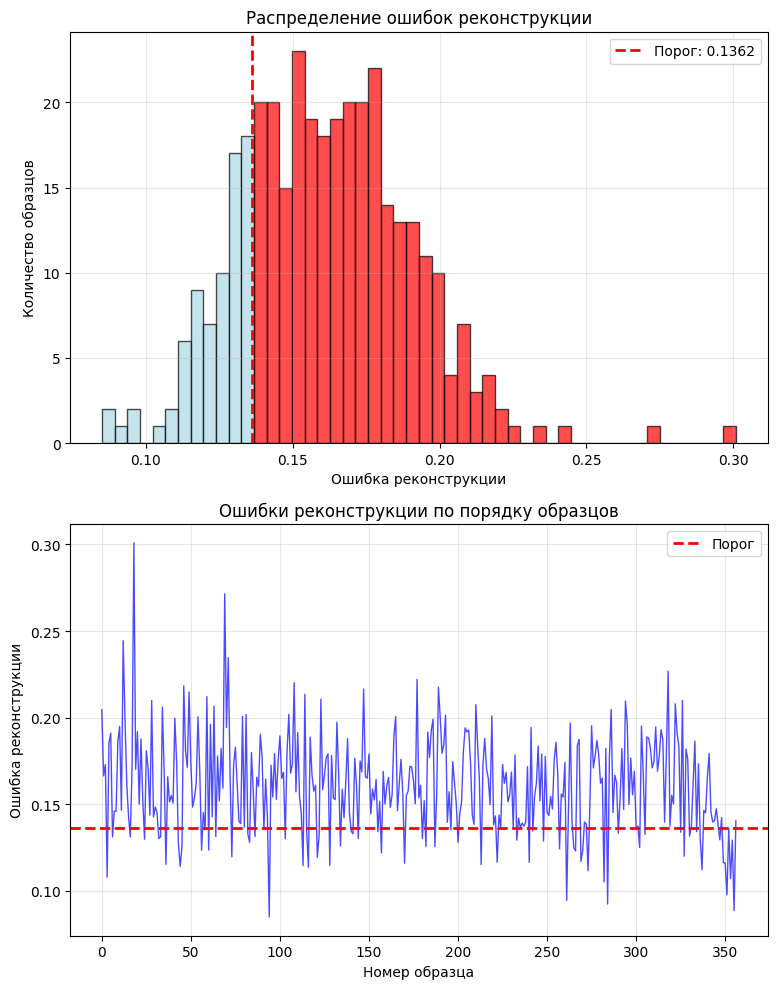


ДЕТАЛЬНАЯ СТАТИСТИКА:
Минимальная ошибка: 0.084998
Максимальная ошибка: 0.300929
Средняя ошибка: 0.160974
Медианная ошибка: 0.160995
Стандартное отклонение: 0.029058

ОБНАРУЖЕНИЕ АНОМАЛИЙ ЗАВЕРШЕНО


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
import joblib

print("=" * 60)
print("ОБНАРУЖЕНИЕ АНОМАЛИЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 60)

# 1. Загрузка тестовой выборки
print("Загрузка тестовой выборки...")
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/is_lab2/WBC_train.txt', sep='\s+', header=None)
X_test = test_data.values + 0.8
print(f"Тестовая выборка загружена: {X_test.shape}")



# 2. Загрузка модели и порога
print("Загрузка модели...")
# Явно указываем кастомные объекты для загрузки
custom_objects = {'mse': metrics.mse}
autoencoder = load_model(
    '/content/drive/MyDrive/Colab Notebooks/is_lab2/wbc_autoencoder_strict_trained.h5',
    custom_objects=custom_objects
)
print("Модель загружена")

print("Загрузка порога...")
threshold_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/is_lab2/autoencoder_threshold.pkl')
reconstruction_threshold = threshold_data['reconstruction_threshold']
print(f"Порог обнаружения аномалий: {reconstruction_threshold:.6f}")

# 3. Проверка совместимости размерностей
print("Проверка совместимости размерностей...")
expected_dim = autoencoder.input_shape[1]
actual_dim = X_test.shape[1]

print(f"Ожидаемая размерность модели: {expected_dim}")
print(f"Фактическая размерность данных: {actual_dim}")

if actual_dim != expected_dim:
    print("Размерности не совпадают")
    if actual_dim > expected_dim:
        X_test = X_test[:, :expected_dim]
    else:
        padding = np.zeros((X_test.shape[0], expected_dim - actual_dim))
        X_test = np.hstack([X_test, padding])
    print(f"Данные скорректированы до: {X_test.shape}")

# 4. Расчет ошибок реконструкции
print("Расчет ошибок реконструкции...")
test_reconstructions = autoencoder.predict(X_test, verbose=1)
test_errors = np.mean(np.square(X_test - test_reconstructions), axis=1)

# 5. Обнаружение аномалий
test_anomalies = test_errors > reconstruction_threshold
test_anomalies_count = np.sum(test_anomalies)
test_anomalies_percentage = (test_anomalies_count / len(test_errors)) * 100

print("\nРЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ:")
print(f"Всего тестовых образцов: {len(test_errors)}")
print(f"Обнаружено аномалий: {test_anomalies_count}")
print(f"Процент аномалий: {test_anomalies_percentage:.2f}%")

# 6. Построение графика ошибок реконструкции
plt.figure(figsize=(15, 10))

# График 1: Распределение ошибок реконструкции
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(test_errors, bins=50, alpha=0.7, color='lightblue', edgecolor='black')

for i in range(len(bins)-1):
    if bins[i] > reconstruction_threshold:
        patches[i].set_facecolor('red')
        patches[i].set_alpha(0.7)

plt.axvline(x=reconstruction_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Порог: {reconstruction_threshold:.4f}')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Количество образцов')
plt.title('Распределение ошибок реконструкции')
plt.legend()
plt.grid(True, alpha=0.3)



# График 3: Ошибки по порядку образцов
plt.subplot(2, 2, 3)
plt.plot(test_errors, 'b-', alpha=0.7, linewidth=1)
plt.axhline(y=reconstruction_threshold, color='red', linestyle='--', linewidth=2, label='Порог')
plt.xlabel('Номер образца')
plt.ylabel('Ошибка реконструкции')
plt.title('Ошибки реконструкции по порядку образцов')
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

# 7. Детальная статистика
print("\nДЕТАЛЬНАЯ СТАТИСТИКА:")
print(f"Минимальная ошибка: {np.min(test_errors):.6f}")
print(f"Максимальная ошибка: {np.max(test_errors):.6f}")
print(f"Средняя ошибка: {np.mean(test_errors):.6f}")
print(f"Медианная ошибка: {np.median(test_errors):.6f}")
print(f"Стандартное отклонение: {np.std(test_errors):.6f}")

print("\n" + "=" * 60)
print("ОБНАРУЖЕНИЕ АНОМАЛИЙ ЗАВЕРШЕНО")
print("=" * 60)